In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os

In [162]:
def process_data(file_path):
    np.arr = np.loadtxt(file_path)
    X = np.arr[:, :9]
    Y = np.arr[:, 9:]
    #print(X.shape)
    #print(Y.shape)
    
    x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size = 0.2)
    #print (x_train.shape, y_train.shape)
    #print (x_test.shape, y_test.shape)
    return x_train, x_test, y_train, y_test

In [164]:
def _init_KNN_clf():
    #intialize paramter grid for grid search
    param_grid = [{
        'n_neighbors': np.arange(1, 50),
        'weights': ['uniform', 'distance']
        
    }]
    
    #initialize cross validation generator
    kfd = KFold(n_splits = 10, shuffle = True, random_state = 1)
    
    #initialize knn classifier with default params (n_neighbors=5 by default) 
    iter_clf = KNeighborsClassifier()
    
    #run grid search to find best hyperparams for classifier
    clf_search = GridSearchCV(iter_clf, param_grid, scoring = 'accuracy', cv=kfd)
    
    return clf_search

In [163]:
def _init_KNN_reg():
    #intialize paramter grid for grid search
    param_grid = [{
        'n_neighbors': np.arange(1,10),
        'weights': ['uniform', 'distance']
    }]
    #initialize cross validation generator
    kfd = KFold(n_splits = 10, shuffle = True, random_state = 1)
    
    #initialize knn regressor with default params (n_neighbors=5 by default)
    iter_reg = KNeighborsRegressor()
    
    #prepare grid search to find best hyperparams for regressor
    reg = GridSearchCV(iter_reg, param_grid, cv=kfd)
    
    return reg

In [166]:
def KNN_classifier(x_train, y_train, x_test, y_test, dataset_name):
    clf_search = _init_KNN_clf()
    
    #run grid search on training data
    clf_search.fit(x_train, y_train.ravel())
    
    best_score = clf_search.best_score_
    best_params = clf_search.best_params_
    clf = clf_search.best_estimator_
    y_pred = clf.predict(x_test)
    results = pd.DataFrame(clf_search.cv_results_)
    
 
    #print(results.columns)
    results_test = pd.DataFrame(results[['mean_test_score','param_weights','param_n_neighbors']])
    uniform_results = results_test[results_test['param_weights'] == 'uniform']
    distance_results = results_test[results_test['param_weights'] == 'distance']
    
    plt.title("KNNTest" + dataset_name)
    line1, = plt.plot(uniform_results['param_n_neighbors'], uniform_results['mean_test_score'], 'b', label='uniform')
    line2, = plt.plot(distance_results['param_n_neighbors'], distance_results['mean_test_score'], 'g', label='distance')
    #plt.plot(np.arange(1,10), scores[9:], 'go')
    plt.xlabel("value of k")
    plt.ylabel("testing accuracy")
    plt.legend(handles=[line1,line2])
    plt.savefig(dataset_name + 'testaccuracy.png')
    plt.draw()
    
    plt.clf()
    
    
#     print ("The best score is: ")
#     print(best_score)
    print("The best parameters are: ")
    print(best_params)

    
    
    test_acc = accuracy_score(y_test, y_pred)
    print('Test accuracy:', test_acc)
   
    
    
    #generate confusion matrix from testing set predictions, set normalize to true so rows will sum to 1
    cm = confusion_matrix(y_test, y_pred, normalize = 'true')
    #cm = cm/cm.astype(np.float).sum(axis = 1)
    
    print("Confusion Matrix: ")
    print(cm)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap='BuGn', normalize='true', values_format = '.2f')
    plt.savefig(dataset_name + 'confusionmatrixnormalized.png')
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,cmap='BuGn')
    plt.savefig(dataset_name + 'confusionmatrix.png')
    plt.show()
    
    

In [171]:
def KNN_regressor(x_train, y_train, x_test, y_test):
    reg = _init_KNN_reg()
    reg.fit(x_train, y_train)
    
    best_params = reg.best_params_
   
    
    #print ("The best score is: ")
    #print(best_score)
    print("The best parameters are: ")
    print(best_params)
    optimalreg = KNeighborsRegressor(n_neighbors = best_params['n_neighbors'], weights = best_params['weights'])
   # optimalreg = KNeighborsRegressor(n_neighbors=3, weights='uniform')
    optimalreg.fit(x_train,y_train)
    
    y_pred = optimalreg.predict(x_test) #generate predictions on testing set
    y_pred = np.where(y_pred > 0.5, 1, 0) #round values to either 0 or 1
    
    total_acc = np.zeros(9)
   # print(accuracy_score(y_test,y_pred, normalize=False))
    #print(accuracy_score(y_test,y_pred, normalize=True))
    for i in range(9):
        total_acc[i] = accuracy_score(y_test[:,i], y_pred[:,i], normalize=False)
    #print(total_acc)
    
    acc = np.sum(total_acc) / (np.shape(y_test)[0] * 9)
    print ("Accuracy knn: {0}".format(acc))
    
    #test_acc = accuracy_score(y_test, y_pred)
    #print('Test accuracy:', test_acc)
    return y_pred
    
    #generate confusion matrix from testing set predictions, set normalize to true so rows will sum to 1
   # cm = confusion_matrix(y_test, y_pred, normalize = 'true')
    #cm = cm/cm.astype(np.float).sum(axis = 1)
    
   # print("Confusion Matrix: ")
   # print(cm)

In [172]:
file_path_multi = 'tictactoedatasets/tictac_multi.txt'

#load tictac_multi dataset
x_train, x_test, y_train, y_test = process_data(file_path_multi)

y_pred = KNN_regressor(x_train, y_train, x_test, y_test)

The best parameters are: 
{'n_neighbors': 9, 'weights': 'distance'}
Accuracy knn: 0.9642342571404356


The best parameters are: 
{'n_neighbors': 1, 'weights': 'uniform'}
Test accuracy: 1.0
Confusion Matrix: 
[[1. 0.]
 [0. 1.]]


<Figure size 432x288 with 0 Axes>

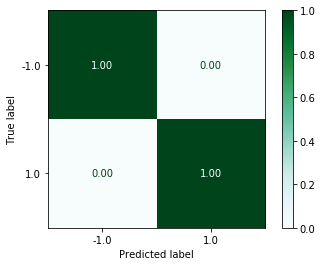

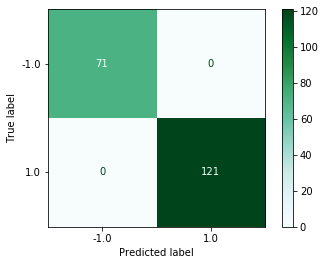

The best parameters are: 
{'n_neighbors': 34, 'weights': 'distance'}
Test accuracy: 0.9282990083905416
Confusion Matrix: 
[[0.97297297 0.         0.02702703 0.         0.         0.
  0.         0.         0.        ]
 [0.01704545 0.90909091 0.02272727 0.         0.02840909 0.00568182
  0.         0.         0.01704545]
 [0.02747253 0.         0.93406593 0.00549451 0.02197802 0.
  0.         0.         0.01098901]
 [0.04672897 0.01869159 0.00934579 0.88785047 0.02803738 0.
  0.00934579 0.         0.        ]
 [0.00460829 0.00921659 0.00460829 0.         0.97695853 0.
  0.         0.         0.00460829]
 [0.05479452 0.05479452 0.         0.01369863 0.         0.84931507
  0.02739726 0.         0.        ]
 [0.05882353 0.         0.         0.         0.03361345 0.
  0.90756303 0.         0.        ]
 [0.05769231 0.09615385 0.         0.         0.         0.
  0.         0.84615385 0.        ]
 [0.06741573 0.03370787 0.01123596 0.         0.01123596 0.
  0.         0.         0.87640449

<Figure size 432x288 with 0 Axes>

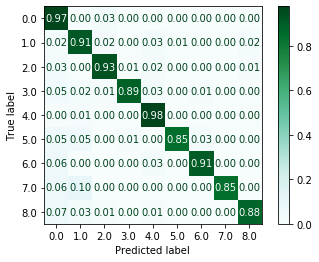

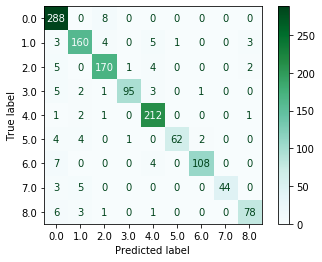

In [173]:
file_path_final = 'tictactoedatasets/tictac_final.txt'
file_path_multi = 'tictactoedatasets/tictac_multi.txt'
file_path_single = 'tictactoedatasets/tictac_single.txt'

#load tictac_final dataset
x_train, x_test, y_train, y_test = process_data(file_path_final)

#evaluate performance of KNN classifier on tictac_final dataset
KNN_classifier(x_train, y_train, x_test, y_test, 'tictac_final')

#load tictac_single dataset
x_train, x_test, y_train, y_test = process_data(file_path_single)

#evaluate performance of KNN classifier on tictac_single dataset
KNN_classifier(x_train, y_train, x_test, y_test, 'tictac_single')